In [5]:
from skimage import io,transform
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
DATASET_PATH='./Train/'
disease_cls=['actinic keratosis','basal cell carcinoma',
             'dermatofibroma','melanoma','nevus',
             'pigmented benign keratosis','seborrheic keratosis',
             'squamous cell carcinoma',
            'vascular lesion']

In [7]:
actinic_keratosis_path=os.path.join(DATASET_PATH,disease_cls[0],'*')
actinic_keratosis=glob.glob(actinic_keratosis_path)


In [8]:
basal_cell_carcinoma_path=os.path.join(DATASET_PATH,disease_cls[1],'*')
basal_cell_carcinoma=glob.glob(basal_cell_carcinoma_path)

In [9]:
actinic=io.imread(actinic_keratosis[0])
basal_cell=io.imread(basal_cell_carcinoma[0])

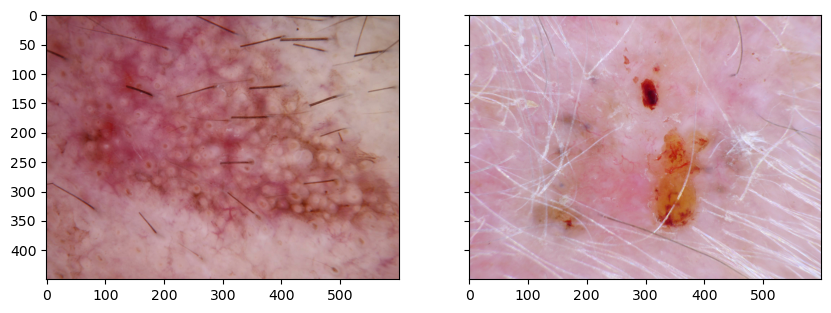

In [10]:
f,axes=plt.subplots(1,2,sharey=True)
f.set_figwidth(10)
axes[0].imshow(actinic,cmap='gray')
axes[1].imshow(basal_cell,cmap='gray')

In [11]:
actinic.shape

(450, 600, 3)

In [12]:
def plot_image(images,Captions=None,cmap=None):
    f,axes=plt.subplots(1,len(images),sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes,images):
        ax.imshow(image,cmap)

In [13]:
new_image=transform.resize(basal_cell,(256,256),anti_aliasing=True)

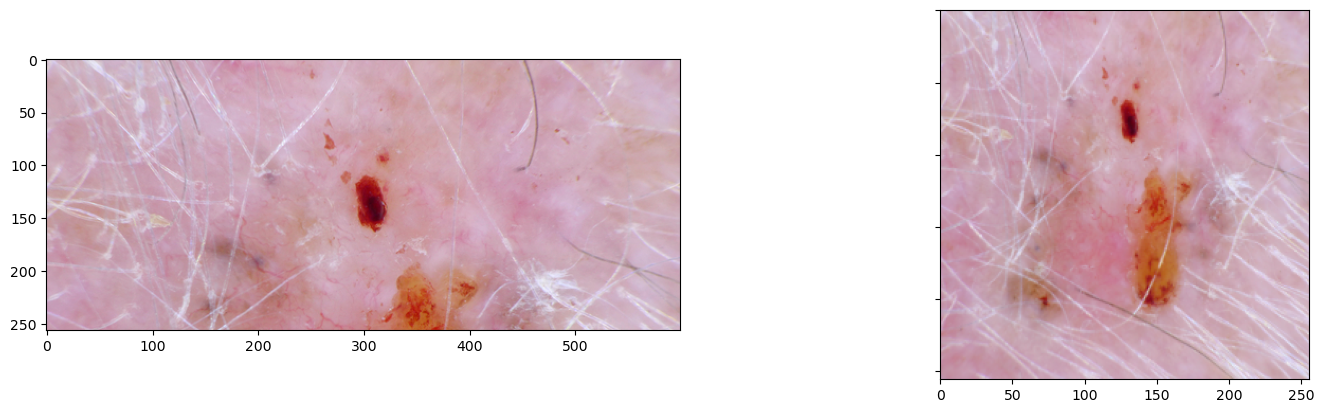

In [14]:
f,axes=plt.subplots(1,2,sharey=True)
f.set_figwidth(18)
axes[0].imshow(basal_cell,cmap=None)
axes[1].imshow(new_image,cmap=None)

In [15]:
new_image.shape

(256, 256, 3)

In [16]:
basal_cell.shape

(450, 600, 3)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(featurewise_center=True,
                           featurewise_std_normalization=True,
                          rotation_range=20,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          shear_range=0.1,
                          zoom_range=0.1,
                          horizontal_flip=True,
                          brightness_range=[0.8,1.2],
                          fill_mode='nearest')
def preprocess_img(img,mode):
    img=img/255.0
    img=transform.resize(img,(256,256),anti_aliasing=True)
    if mode=='train':
        if np.random.randn()>0:
            img=datagen.random_transform(img)
    return img

In [82]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,mode='Train',ablation=None,disease_cls=disease_cls,
                batch_size=32,dim=(256,256),n_channels=3,shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode=mode

        # glob through directory of each class
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})

        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)     

    def __data_generation(self,list_IDs_temp):
        X=np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        for i,ID in enumerate(list_IDs_temp):
            img=io.imread(ID)
            img=preprocess_img(img,self.mode)
            X[i]=img
            y[i]=self.labels[ID]
                
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
                
                
        
        
        
            
        

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model



In [84]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=kernel_size, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def resnet_block(x, filters, blocks, stride=1):
    x = residual_block(x, filters, stride=stride)
    for _ in range(1, blocks):
        x = residual_block(x, filters)
    return x

def ResNet(input_shape, num_classes, layers):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64, layers[0])
    x = resnet_block(x, 128, layers[1], stride=2)
    x = resnet_block(x, 256, layers[2], stride=2)
    x = resnet_block(x, 512, layers[3], stride=2)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def resnet18(input_shape, num_classes):
    return ResNet(input_shape, num_classes, [2, 2, 2, 2])

def resnet34(input_shape, num_classes):
    return ResNet(input_shape, num_classes, [3, 4, 6, 3])

In [90]:
#using resnet18
model=resnet18((256,256,3),len(disease_cls))

In [91]:
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

In [92]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

In [88]:
training_generator

In [ ]:
model.fit(training_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 461s 8s/step - accuracy: 0.2010 - loss: 2.2678 - val_accuracy: 0.2656 - val_loss: 2.1200
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 436s 7s/step - accuracy: 0.2759 - loss: 1.9861 - val_accuracy: 0.2589 - val_loss: 2.0214
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 458s 8s/step - accuracy: 0.3014 - loss: 1.8664 - val_accuracy: 0.2076 - val_loss: 2.1754
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 469s 8s/step - accuracy: 0.3172 - loss: 1.8567 - val_accuracy: 0.3281 - val_loss: 1.8521
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 453s 8s/step - accuracy: 0.3106 - loss: 1.7600 - val_accuracy: 0.3103 - val_loss: 1.9816
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 448s 8s/step - accuracy: 0.3332 - loss: 1.7740 - val_accuracy: 0.3772 - val_loss: 2.1340
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 435s 7s/step - accuracy: 0.3376 - loss: 1.7216 - val_accuracy: 0.3326 - val_loss: 1.8972
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 454s 8s/step - accuracy: 0.3130 - loss: 1.7702 - val_accuracy: 0.4040 - v